In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from textwrap import indent

from IPython.display import Javascript

from liblet import ANTLR, AnnotatedTreeWalker, Tree, pyast2tree, side_by_side

from operator import add, mul, truediv, sub

from operator import itemgetter

from IPython.display import Latex

from fractions import Fraction

import importlib

from core.arithmetic_manager import ArithManager

from core.util import *

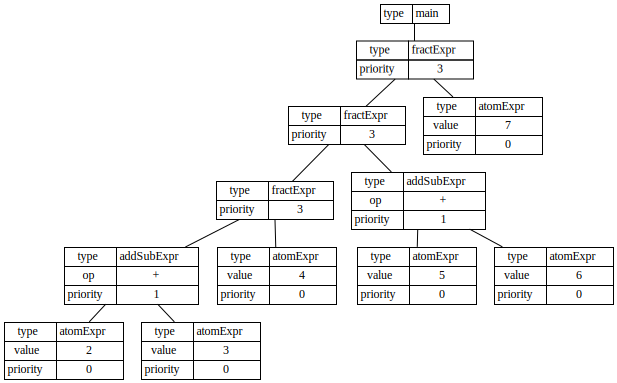

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [22]:
ex1 = '1 + {2 x [(3 + 4 : 2) + 5] x 6} - [ 7 + (1 + 8) : 3 ] x [ 9 : (2 + 1) + 2 ]'
ex2 = '< 2 + 3 > / 4 / < 5 + 6 > / 7'
ex3 = '2 ^ < 3 + 4 ^ 5 : 2 ^ 7 >'
ex4 = '3 + 13 x -<1 + 3>/<2^<1+4> - 6>'
ex5a = '3 / < 4 + 2 > + 2 x { 3 : ( 4 + 5 ) + 2 ^ < 6 x 1/2 > } - < 2 x [ 5 x ( 3 + 4 ) + 5 ] - 1 > / 6'
ex5b = '3 / < 4 + 2 > + 2 x ( 3 : ( 4 + 5 ) + 2 ^ < 6 x 1/2 > ) - < 2 x ( 5 x ( 3 + 4 ) + 5 ) - 1 > / 6'

src = '(2^-1/3 + 0.5 + 8 - 2.3 x 2.1 - 2 + (((2 + 3) + 1) - 1) + (2 + (2 - 2 x (8 + 9 - (5 x 6))))):0'
expr = '( 3 + 4 - 4 : 1 ) / 5'

src = ex2
AM = ArithManager()
ast = AM.ptree2ast(AM.ptree('antlrGrammar.g', src))
blocks = AM.blocks(ast)
MEMORY = dict(blocks)

display(ast)

main_block = blocks[-1][1]
child_to_calc = None

current_block = block_id = None

while blocks and is_calculable(blocks[0][1]): blocks = blocks[1:]
    
while blocks:
    block_id, current_block = blocks[0]
        
    parent_to_calc = AM.prior(current_block)
    display_latex(AM.latex(main_block, MEMORY))

    parent_to_calc.children =  [Tree({'type': 'atomExpr', 'value': AM.eval(child, MEMORY), 'priority': 0, '_calc': 'last'}, []) 
                                if is_next_to_calc(child) else child
                                for child in parent_to_calc.children]
    
    if is_calculable(current_block):
        current_block = current_block.children[0]
        blocks = blocks[1:]
        
    MEMORY[block_id] = current_block

display_latex(AM.latex(main_block, {}))

In [4]:
with open("core/atw_expr_eval.py") as f:
    print(f.read())

from fractions import Fraction

from liblet import AnnotatedTreeWalker, Tree, Stack

from core.block_depth import BlockDepth
from core.my_atw import MyAtw
from core.util import *

from operator import add, mul, truediv, sub


class AtwEvalExpr(MyAtw):
    ARITH_OP = {
        '+': add,
        '-': sub,
        'x': mul,
        ':': Fraction,
        '/': Fraction
    }


    def __init__(self):
        super().__init__('type')
        self.MEMORY = {}

    def start(self, ast, memory):
        self.MEMORY = memory
        return self(ast)

    def _atw_atomExpr(self, ast):
        return ast.root['value']


    def _atw_subExpr(self, ast):
        return self.MEMORY[ast.root['ID']].root['value']

    @check_type
    def _atw_addSubExpr(self, ast):
        left, right = ast.children
        op = ast.root['op']
        left, right = self(left), self(right)
        return AtwEvalExpr.ARITH_OP[op](left, right)

    @check_type
    def _atw_divProdExpr(self, ast):
        left, right = as

In [5]:
from decimal import Decimal
str(Decimal('%.2E' % 1000000))

'1.00E+6'

In [6]:
isinstance(8.0, int)
Fraction(1.333)
8.4.is_integer()
isinstance(Fraction(4, 2), int)
int(Fraction(4, 2))

2

In [7]:
import re
if re.match(r'_atw_[^\W\d_]+', '_atw_'):
    print('ski')

In [8]:
src = '(4 + 5)'


arithExpr = ArithManager.arith_expr('antlrGrammar.g')
ast = ArithManager.ptree2ast(ArithManager.ptree(arithExpr, src))
ast

AttributeError: type object 'ArithManager' has no attribute 'arith_expr'